# Predicting Bike Rental Usage

In this project we'll be using a dataset containing information
about the daily usage of bike rentals in the districts of Washington D.C.
This dataset can be downloaded at [University of California Irvine website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
where each row represents the number of bike rentals for a single hour
of a single day.

The description of the relevant columns is:
* instant - A unique sequential ID number for each row
* dteday - The date of the rentals
* season - The season in which the rentals occurred
* yr - The year the rentals occurred
* mnth - The month the rentals occurred
* hr - The hour the rentals occurred
* holiday - Whether or not the day was a holiday
* weekday - The day of the week (as a number, 0 to 7)
* workingday - Whether or not the day was a working day
* weathersit - The weather (as a categorical variable)
* temp - The temperature, on a 0-1 scale
* atemp - The adjusted temperature
* hum - The humidity, on a 0-1 scale
* windspeed - The wind speed, on a 0-1 scale
* casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* registered - The number of registered riders (people who had already signed up)
* cnt - The total number of bike rentals (casual + registered)

The objective of the project is to predict the total number of bikes
people rented in a single hour. To accomplish this we'll create
different machine learning models and evaluate their performance.

In [1]:
import pandas as pd
data = pd.read_csv('hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Exploration

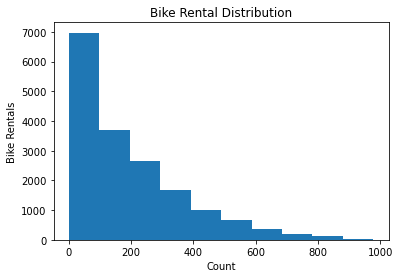

In [2]:
import matplotlib.pyplot as plt

plt.hist(data['cnt'])
plt.xlabel('Count')
plt.ylabel('Bike Rentals')
plt.title('Bike Rental Distribution')
plt.show()

In [3]:
correlations = data.corr()
correlations['cnt'].sort_values()

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

<AxesSubplot:>

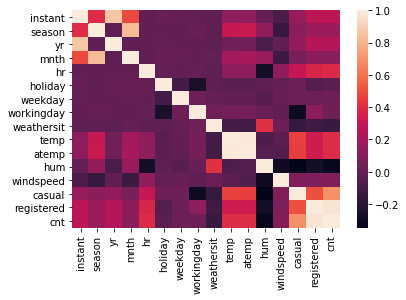

In [4]:
from seaborn import heatmap
heatmap(correlations)

## Feature Engineering

First we'll create a column that indicates the time of the day of the bike rental. We'll assign morning(1),
afternoon(2), evening(4), and night(4)

In [5]:
def assign_time_of_day(hour):

    if hour/6 <= 1:
        return 1
    elif hour/6 <= 2:
        return 2
    elif hour/6 <= 3:
        return 3
    elif hour/6 <= 4:
        return 4

data['time_label'] = data['hr'].apply(assign_time_of_day)
data.sample(n=5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
4386,4387,2011-07-06,3,0,7,16,0,3,1,1,0.76,0.7273,0.70,0.2537,57,218,275,3
14325,14326,2012-08-25,3,1,8,2,0,6,0,2,0.66,0.6212,0.74,0.0896,18,61,79,1
6370,6371,2011-09-28,4,0,9,0,0,3,1,1,0.60,0.5455,0.88,0.0000,7,29,36,1
11947,11948,2012-05-18,2,1,5,0,0,5,1,1,0.52,0.5000,0.59,0.1045,13,57,70,1
1692,1693,2011-03-16,1,0,3,4,0,3,1,2,0.30,0.3030,0.93,0.1642,0,1,1,1


In [6]:
train = data.sample(n=int(data.shape[0]*.8))
train.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
8058,8059,2011-12-07,4,0,12,10,0,3,1,3,0.44,0.4394,1.00,0.0896,1,32,33,2
10532,10533,2012-03-19,1,1,3,23,0,1,1,2,0.56,0.5303,0.78,0.1343,9,45,54,4
4344,4345,2011-07-04,3,0,7,22,1,1,0,2,0.74,0.6818,0.62,0.1343,115,211,326,4
13828,13829,2012-08-04,3,1,8,9,0,6,0,1,0.78,0.7576,0.65,0.2239,61,217,278,2
9159,9160,2012-01-22,1,1,1,13,0,0,0,2,0.16,0.1818,0.80,0.1343,24,175,199,3


In [7]:
test = data[~data.index.isin(train.index)]
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,2
23,24,2011-01-01,1,0,1,23,0,6,0,2,0.46,0.4545,0.88,0.2985,15,24,39,4
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,1,16,17,1
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,2,4,6,1
29,30,2011-01-02,1,0,1,6,0,0,0,3,0.42,0.4242,0.77,0.2985,0,2,2,1


## Feature Selection

Now we'll select the features excluding those that provide redundant information or leak information of the
target variable.

In [8]:
excluded = ['cnt', 'casual', 'dteday', 'registered', 'atemp']
features = [col for col in data.columns if col not in excluded]

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(data[features], data['cnt'])
predictions = lr.predict(test[features])

## Error

We will pick the mean square error (MSE) as our error metric since it works well on continuous numeric data,
which fits our data quite well.

In [10]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['cnt'], predictions)
rmse = mse ** (1/2)
print(rmse)

144.35830380302528


The error obtained is really high and may be due to MSE punishing heavily outliers. This could also be due
to the relationship between the variables not having a linear relationship and therefore making a LR a bad
model decision.


## Decision Tree

In [20]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_leaf=5, max_depth=15, random_state=15)
dtr.fit(train[features], train['cnt'])
predictions = dtr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
rmse = mse ** (1/2)
print(rmse)

51.71256781295199


The error improved considerably compared to the Linear Regression Model. Now lets try to decrease it even
further by applying Random Forest.

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5,
                           max_depth=15,
                           n_estimators=200,
                           max_features='auto',
                           random_state=15)

rf.fit(train[features], train['cnt'])
predictions = rf.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
rmse = mse ** (1/2)
print(rmse)


42.81469753650892


By building a more robust decision tree by using imputation and feature sampling Random Forest was able to
improve on the accuracy from the decision tree.
